<center>
<table>
  <tr>
    <td><img src="https://portal.nccs.nasa.gov/datashare/astg/training/python/logos/nasa-logo.svg" width="100"/> </td>
     <td><img src="https://portal.nccs.nasa.gov/datashare/astg/training/python/logos/ASTG_logo.png?raw=true" width="80"/> </td>
     <td> <img src="https://www.nccs.nasa.gov/sites/default/files/NCCS_Logo_0.png" width="130"/> </td>
    </tr>
</table>
</center>

        
<center>
<h2><font color= "blue" size="+3">PyCon 2024 Tutorial</font></h2>
</center>

---

<center>
    <h3>Python Workflows to Extract and Plot Satellite Data Products along Tracks</h3>
    <h2><font color="red" size="+3">Background</font></h2>
</center>

----
[Jules Kouatchou](mailto:Jules.Kouatchou@nasa.gov) • [Bruce Van Aartsen](mailto:bruce.vanaartsen@nasa.gov)
-
----

## <font color="red"> Objectives</font>

- We want to show the steps we need to take after we collect timeseries data (locations and fields) of a moving object.
- We use `Pandas`, `Shapely`, `GeoPandas` and `MovingPandas` to process the data, perform analyses and do visualization.

We particularly want to do a quick introduction on `Pandas`, `GeoPandas` and `MovingPandas` that are the main packages we will be using to track the movement of a planar object.

## <font color="red">Movement of planar objects</font>

- In this tutorial, we are interested in tracking the movement of objects in a two-dimensional space or plane.
   - We assume that an object is considered to be a single point.
- Over a time period, we want to collect data from the movement, where each data point contains:
   - The date/time
   - The location (latitude and longitude)
   - (optionally) Measurements at the location
- With the timeseries dataset, we can:
   - Compute parameters such as distance, speed, etc.
   - Perform visualizations.
   - Compare measurements against model simulations.

### <font color="blue">Examples</font>
- __The eye of an hurricane__
- Track the movement of a car
- Track the movement of a ship
- __Movement of a total solar eclipse__
- Movement of (basketball, soccer, football, etc.) players
- __The International Space Station (ISS)__
- __Movement of a satellite__

---

## <font color="red">Required Packages</font>

- __Matplotlib__: for basic plots.
- __Pandas__: Manipulation and exploratory data analysis of tabular data.
- __Shapely__: For manipulation and analysis of planar geometric objects
- __GeosPandas__: Combines the capabilities of Pandas and Shapely for geospatial operations
- __MovingPandas__: Handling the movement of geospatial objects.

----

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [4]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [6]:
import movingpandas as mpd

In [7]:
import holoviews as hv

In [8]:
import hvplot.pandas 

In [9]:
plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
hv.opts.defaults(hv.opts.Overlay(active_tools=['wheel_zoom'], 
                              frame_width=500, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

In [10]:
mpd.show_versions()


MovingPandas 0.19.0

SYSTEM INFO
-----------
python     : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
executable : c:\Users\joshu\anaconda3\python.exe
machine    : Windows-11-10.0.22621-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.2
GDAL data dir: None
PROJ       : 9.3.1
PROJ data dir: c:\Users\joshu\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.4
pandas     : 2.2.2
fiona      : 1.9.5
numpy      : 1.26.4
shapely    : 2.0.5
pyproj     : 3.6.1
matplotlib : 3.8.4
mapclassify: 2.5.0
geopy      : 2.4.1
holoviews  : 1.19.0
hvplot     : 0.10.0
geoviews   : None
stonesoup  : None


![fig_pd](https://pandas.pydata.org/docs/_static/pandas.svg)

- Pandas is a Python package providing fast, flexible, and expressive data structures designed to make working with two-dimensional labeled data both easy and intuitive.
- It aims to be the fundamental high-level building block for doing practical, real-world data analysis in Python.

### <font color="blue">Example</font>

Consider the [forecast of the track of the hurricane KATRINA in 2005](https://www.esl.lsu.edu/hurricanes/2005/KATRINA/) that consists of the following:

- The dates/times
- The locations (in terms of latitudes and longitudes)
- Three fields at each location
   - Pressure (mbar)
   - Max Winds (kts)
   - Max Gust (kts)

We can use the `read_csv` function to read the remote file:

In [11]:
url = "https://www.esl.lsu.edu/hurricanes/447/csv"

In [12]:
import datetime
dateparse = lambda x: datetime.datetime.strptime(x, '%y%m%d %H')
df = pd.read_csv(url, 
                 skiprows=[1],
                 parse_dates={'1': [0]}, 
                 date_parser=dateparse,
                )

df

,1,Latitude,Longitude,Pressure,Max Winds,Max Gust
0,2005-08-24 02:00:00,23.2,-75.5,1007,30,40
1,2005-08-24 08:00:00,23.4,-76.0,1007,30,40
2,2005-08-24 14:00:00,24.0,-76.4,1006,30,40
3,2005-08-24 20:00:00,24.7,-76.7,1006,35,45
4,2005-08-25 02:00:00,25.6,-77.2,1002,40,50
5,2005-08-25 08:00:00,26.0,-78.0,1001,45,55
6,2005-08-25 14:00:00,26.2,-78.7,1000,45,55
7,2005-08-25 20:00:00,26.2,-79.3,997,50,60
8,2005-08-26 02:00:00,26.1,-79.9,985,65,80
9,2005-08-26 08:00:00,25.5,-80.7,984,65,80


We can get basic information on the columns:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   1          32 non-null     datetime64[ns]
 1   Latitude   32 non-null     float64       
 2   Longitude  32 non-null     float64       
 3   Pressure   32 non-null     int64         
 4   Max Winds  32 non-null     int64         
 5   Max Gust   32 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 1.6 KB


We can rename the columns (so that each column name is in one word only):

In [14]:
df.columns = ['t', 'latitude', 'longitude', 'pressure', 'max_winds', 'max_gust']
df

,t,latitude,longitude,pressure,max_winds,max_gust
0,2005-08-24 02:00:00,23.2,-75.5,1007,30,40
1,2005-08-24 08:00:00,23.4,-76.0,1007,30,40
2,2005-08-24 14:00:00,24.0,-76.4,1006,30,40
3,2005-08-24 20:00:00,24.7,-76.7,1006,35,45
4,2005-08-25 02:00:00,25.6,-77.2,1002,40,50
5,2005-08-25 08:00:00,26.0,-78.0,1001,45,55
6,2005-08-25 14:00:00,26.2,-78.7,1000,45,55
7,2005-08-25 20:00:00,26.2,-79.3,997,50,60
8,2005-08-26 02:00:00,26.1,-79.9,985,65,80
9,2005-08-26 08:00:00,25.5,-80.7,984,65,80


We want the values of the three fields to be floating point numbers:

In [15]:
df = df.astype({'pressure':'float64', 
                'max_winds':'float64', 
                'max_gust': 'float64'})
df

,t,latitude,longitude,pressure,max_winds,max_gust
0,2005-08-24 02:00:00,23.2,-75.5,1007.0,30.0,40.0
1,2005-08-24 08:00:00,23.4,-76.0,1007.0,30.0,40.0
2,2005-08-24 14:00:00,24.0,-76.4,1006.0,30.0,40.0
3,2005-08-24 20:00:00,24.7,-76.7,1006.0,35.0,45.0
4,2005-08-25 02:00:00,25.6,-77.2,1002.0,40.0,50.0
5,2005-08-25 08:00:00,26.0,-78.0,1001.0,45.0,55.0
6,2005-08-25 14:00:00,26.2,-78.7,1000.0,45.0,55.0
7,2005-08-25 20:00:00,26.2,-79.3,997.0,50.0,60.0
8,2005-08-26 02:00:00,26.1,-79.9,985.0,65.0,80.0
9,2005-08-26 08:00:00,25.5,-80.7,984.0,65.0,80.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   t          32 non-null     datetime64[ns]
 1   latitude   32 non-null     float64       
 2   longitude  32 non-null     float64       
 3   pressure   32 non-null     float64       
 4   max_winds  32 non-null     float64       
 5   max_gust   32 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.6 KB


#### Let us plot the location:

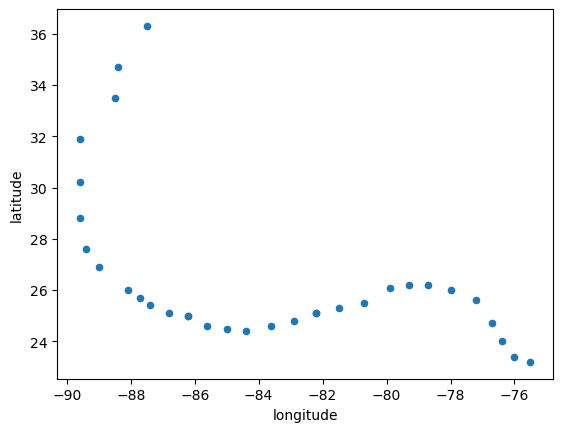

In [17]:
df.plot(kind="scatter", x='longitude', y='latitude');

![fig_gpd](https://geopandas.org/en/stable/_static/geopandas_logo_web.svg)

- A Python library that allows you to process shapefiles representing tabular data (like Pandas), where every row is associated with a geometry.
- Designed to primarily work with vector data.
- Extends the capabilities of Pandas to enable spatial operations on geometric types.
  - Geometric operations are performed by Shapely.
- Includes new data types such as `GeoDataFrame` and `GeoSeries` which are subclasses of Pandas DataFrame and Series and enables efficient vector data processing in Python. 

### <font color="blue">GeoDataFrame</font>
- A tabular data structure that contains a "geometry" column.
- The geometry column defines a point, line, or polygon associated with the rest of the columns. This column is a collection of `Shapely` objects. 
- The Coordinate Reference System (CRS) is the coordinate reference system of the geometry column that tells us where a point, line, or polygon lies on the Earth's surface. GeoPandas maps a geometry onto the Earth's surface.
- The “geometry” column – no matter its name – can be accessed through the geometry attribute (`gdf.geometry`), and the name of the `geometry` column can be found by typing `gdf.geometry.name`.


![fig_frame](https://geopandas.org/en/stable/_images/dataframe.svg)
Image Source: [GeoPandas](https://geopandas.org/en/stable/getting_started/introduction.html)

#### Add a `'geometry'` column to the Pandas DataFrame

Convert the positions (latitude and longitude) into Shapely POINT objects:

In [18]:
df['geometry'] = [shpgeom.Point(xy) for xy in zip(df['longitude'], df['latitude'])] 
df

,t,latitude,longitude,pressure,max_winds,max_gust,geometry
0,2005-08-24 02:00:00,23.2,-75.5,1007.0,30.0,40.0,POINT (-75.5 23.2)
1,2005-08-24 08:00:00,23.4,-76.0,1007.0,30.0,40.0,POINT (-76 23.4)
2,2005-08-24 14:00:00,24.0,-76.4,1006.0,30.0,40.0,POINT (-76.40000000000001 24)
3,2005-08-24 20:00:00,24.7,-76.7,1006.0,35.0,45.0,POINT (-76.7 24.7)
4,2005-08-25 02:00:00,25.6,-77.2,1002.0,40.0,50.0,POINT (-77.2 25.6)
5,2005-08-25 08:00:00,26.0,-78.0,1001.0,45.0,55.0,POINT (-78 26)
6,2005-08-25 14:00:00,26.2,-78.7,1000.0,45.0,55.0,POINT (-78.7 26.2)
7,2005-08-25 20:00:00,26.2,-79.3,997.0,50.0,60.0,POINT (-79.3 26.2)
8,2005-08-26 02:00:00,26.1,-79.9,985.0,65.0,80.0,POINT (-79.90000000000001 26.1)
9,2005-08-26 08:00:00,25.5,-80.7,984.0,65.0,80.0,POINT (-80.7 25.5)


#### Create a GeoDataFrame from the Pandas DataFrame

In [19]:
gdf = gpd.GeoDataFrame(df, geometry="geometry") 
gdf

,t,latitude,longitude,pressure,max_winds,max_gust,geometry
0,2005-08-24 02:00:00,23.2,-75.5,1007.0,30.0,40.0,POINT (-75.50000 23.20000)
1,2005-08-24 08:00:00,23.4,-76.0,1007.0,30.0,40.0,POINT (-76.00000 23.40000)
2,2005-08-24 14:00:00,24.0,-76.4,1006.0,30.0,40.0,POINT (-76.40000 24.00000)
3,2005-08-24 20:00:00,24.7,-76.7,1006.0,35.0,45.0,POINT (-76.70000 24.70000)
4,2005-08-25 02:00:00,25.6,-77.2,1002.0,40.0,50.0,POINT (-77.20000 25.60000)
5,2005-08-25 08:00:00,26.0,-78.0,1001.0,45.0,55.0,POINT (-78.00000 26.00000)
6,2005-08-25 14:00:00,26.2,-78.7,1000.0,45.0,55.0,POINT (-78.70000 26.20000)
7,2005-08-25 20:00:00,26.2,-79.3,997.0,50.0,60.0,POINT (-79.30000 26.20000)
8,2005-08-26 02:00:00,26.1,-79.9,985.0,65.0,80.0,POINT (-79.90000 26.10000)
9,2005-08-26 08:00:00,25.5,-80.7,984.0,65.0,80.0,POINT (-80.70000 25.50000)


In [20]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

#### Basic visualization

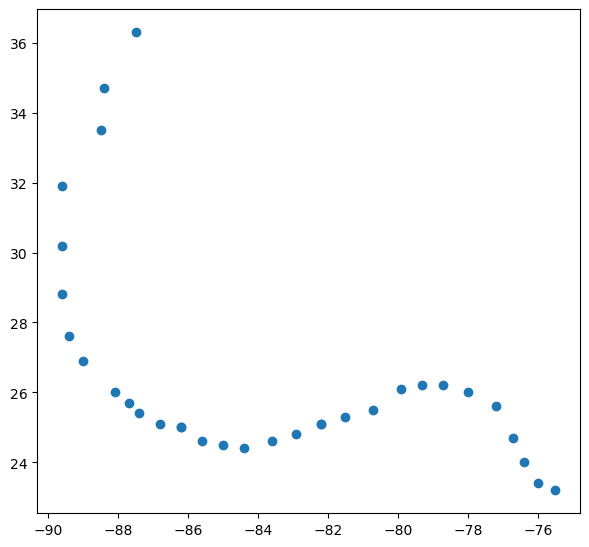

In [21]:
gdf.plot(figsize=(7,10));

In [23]:
gdf.hvplot(tiles='EsriTerrain', coastline=True, 
           hover_cols=["t", "pressure", "max_winds", "max_gust"])

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Points.I    :Points   [Longitude,Latitude]   (t,pressure,max_winds,max_gust)
   .Coastline.I :Feature   [Longitude,Latitude]

#### Introduce a buffer along the track

Create a line string connecting the points:

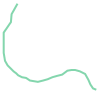

In [24]:
track = shpgeom.LineString( [[a.x, a.y] for a in gdf.geometry.values] )
track

Add a buffer around the track:

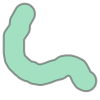

In [25]:
track_buffer = track.buffer(2)
track_buffer

Create a DataFrame with a "geomtery" column have only the `track` as entry:

In [26]:
df_track = pd.DataFrame({"geometry": track}, index=[0])
df_track

,geometry
0,"LINESTRING (-75.5 23.2, -76 23.4, -76.40000000..."


Create the corresponding GeoDataFrame:

In [27]:
gdf_track = gpd.GeoDataFrame(df_track, geometry="geometry")
gdf_track

,geometry
0,"LINESTRING (-75.50000 23.20000, -76.00000 23.4..."


Add the buffer:

In [28]:
gdf_track_buffer = gpd.GeoDataFrame(geometry=gdf_track.buffer(0.5))
gdf_track_buffer

,geometry
0,"POLYGON ((-76.18570 22.93576, -76.23128 22.956..."


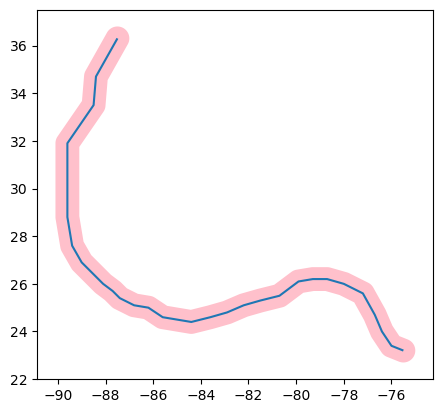

In [29]:
fig, ax = plt.subplots()
gdf_track_buffer.plot(ax=ax, color="pink", )
gdf_track.plot(ax=ax);

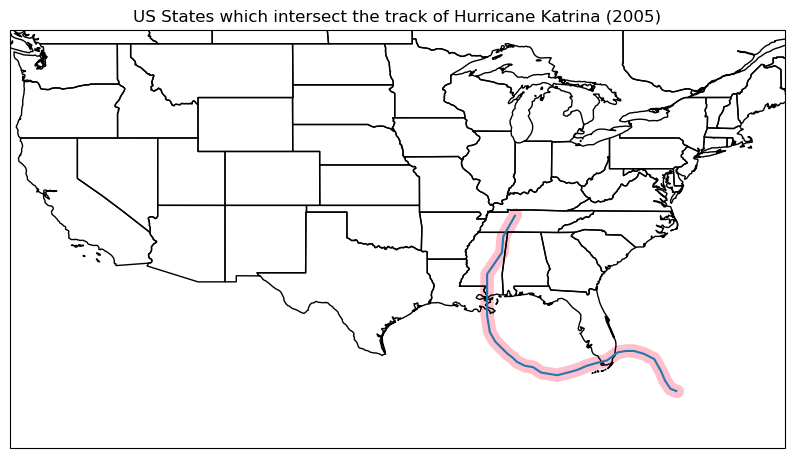

In [30]:
import cartopy
import cartopy.crs as ccrs

pc = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection=pc)#ccrs.LambertConformal())
ax.patch.set_visible(False)
ax.set_extent([-125, -67.5, 19, 50], pc)

ax.add_feature(cartopy.feature.LAND, facecolor='w')
ax.add_feature(cartopy.feature.OCEAN, facecolor='w')
ax.add_feature(cartopy.feature.STATES)

gdf_track_buffer.plot(ax=ax, color="pink")
gdf_track.plot(ax=ax)
ax.set_title('US States which intersect the track of Hurricane Katrina (2005)');

---

![fig_logo](https://movingpandas.github.io/movingpandas/assets/img/logo-wide.svg)

- A Python library (based on Pandas, GeoPandas and HoloViz) for handling the movement of geospatial objects.
-  The key features of MovingPandas for movement data exploration are related to data import,
visualization, and spatiotemporal analysis.
- Provides trajectory data structures and functions (such as length, duration, and speed computations) for movement data exploration and analysis.
- A trajectory is:
   - A time-ordered series of geometries. The geometries and associated attributes are stored in a GeoPandas GeoDataFrame.
   - __Can be seen as a sequence of points that specify the position of a moving object in space and time__.
   - A segment is a part of the trajectory that contains a list of episodes. 
       - Each episode has a starting and ending timestamp, a segmentation criterion (annotation type), and an episode annotation. 
       - For instance, an annotation type can be the “weather conditions”, and an episode annotation can be “a storm”, “heavy rain”, “extremely high waves”, etc.




#### Create a MovingPandas trajectory

In [31]:
mdf_traj = mpd.Trajectory(df, 
                          traj_id=1, 
                          x = "longitude", y="latitude", t="t")

mdf_traj

Trajectory 1 (2005-08-24 02:00:00 to 2005-08-30 20:00:00) | Size: 30 | Length: 2772460.5m
Bounds: (-89.6, 23.2, -75.5, 36.3)
LINESTRING (-75.5 23.2, -76 23.4, -76.40000000000001 24, -76.7 24.7, -77.2 25.6, -78 26, -78.7 26.2,

In [32]:
mdf_traj.df

,pressure,max_winds,max_gust,geometry,traj_id
t,,,,,
2005-08-24 02:00:00,1007.0,30.0,40.0,POINT (-75.50000 23.20000),1
2005-08-24 08:00:00,1007.0,30.0,40.0,POINT (-76.00000 23.40000),1
2005-08-24 14:00:00,1006.0,30.0,40.0,POINT (-76.40000 24.00000),1
2005-08-24 20:00:00,1006.0,35.0,45.0,POINT (-76.70000 24.70000),1
2005-08-25 02:00:00,1002.0,40.0,50.0,POINT (-77.20000 25.60000),1
2005-08-25 08:00:00,1001.0,45.0,55.0,POINT (-78.00000 26.00000),1
2005-08-25 14:00:00,1000.0,45.0,55.0,POINT (-78.70000 26.20000),1
2005-08-25 20:00:00,997.0,50.0,60.0,POINT (-79.30000 26.20000),1
2005-08-26 02:00:00,985.0,65.0,80.0,POINT (-79.90000 26.10000),1


#### Determine the start date, end date and duration of the trajectory

In [33]:
mdf_traj.get_start_time()

datetime.datetime(2005, 8, 24, 2, 0)

In [34]:
mdf_traj.get_end_time()

datetime.datetime(2005, 8, 30, 20, 0)

In [35]:
mdf_traj.get_duration()

datetime.timedelta(days=6, seconds=64800)

#### Compute the sampling interval (median time difference between records)

In [36]:
mdf_traj.get_sampling_interval()

Timedelta('0 days 06:00:00')

#### Compute the length of the trajectory

In [37]:
str(mdf_traj.get_start_location())

'POINT (-75.5 23.2)'

In [38]:
str(mdf_traj.get_end_location())

'POINT (-87.5 36.3)'

In [39]:
mdf_traj.get_length(units="mi")

1722.7270652752545

#### Add the `distance` and the `speed` columns

- MovingPandas has built-in functions to compute the distance and speed

In [40]:
mdf_traj.add_distance(overwrite=True, units="mi")
mdf_traj.df

,pressure,max_winds,max_gust,geometry,traj_id,distance
t,,,,,,
2005-08-24 02:00:00,1007.0,30.0,40.0,POINT (-75.50000 23.20000),1,0.000000
2005-08-24 08:00:00,1007.0,30.0,40.0,POINT (-76.00000 23.40000),1,34.633542
2005-08-24 14:00:00,1006.0,30.0,40.0,POINT (-76.40000 24.00000),1,48.451341
2005-08-24 20:00:00,1006.0,35.0,45.0,POINT (-76.70000 24.70000),1,51.757988
2005-08-25 02:00:00,1002.0,40.0,50.0,POINT (-77.20000 25.60000),1,69.418752
2005-08-25 08:00:00,1001.0,45.0,55.0,POINT (-78.00000 26.00000),1,56.950986
2005-08-25 14:00:00,1000.0,45.0,55.0,POINT (-78.70000 26.20000),1,45.636604
2005-08-25 20:00:00,997.0,50.0,60.0,POINT (-79.30000 26.20000),1,37.262694
2005-08-26 02:00:00,985.0,65.0,80.0,POINT (-79.90000 26.10000),1,37.908905


In [41]:
mdf_traj.add_speed(overwrite=True, 
              name="speed", units=("mi", "h"))

mdf_traj.df

,pressure,max_winds,max_gust,geometry,traj_id,distance,speed
t,,,,,,,
2005-08-24 02:00:00,1007.0,30.0,40.0,POINT (-75.50000 23.20000),1,0.000000,5.772257
2005-08-24 08:00:00,1007.0,30.0,40.0,POINT (-76.00000 23.40000),1,34.633542,5.772257
2005-08-24 14:00:00,1006.0,30.0,40.0,POINT (-76.40000 24.00000),1,48.451341,8.075224
2005-08-24 20:00:00,1006.0,35.0,45.0,POINT (-76.70000 24.70000),1,51.757988,8.626331
2005-08-25 02:00:00,1002.0,40.0,50.0,POINT (-77.20000 25.60000),1,69.418752,11.569792
2005-08-25 08:00:00,1001.0,45.0,55.0,POINT (-78.00000 26.00000),1,56.950986,9.491831
2005-08-25 14:00:00,1000.0,45.0,55.0,POINT (-78.70000 26.20000),1,45.636604,7.606101
2005-08-25 20:00:00,997.0,50.0,60.0,POINT (-79.30000 26.20000),1,37.262694,6.210449
2005-08-26 02:00:00,985.0,65.0,80.0,POINT (-79.90000 26.10000),1,37.908905,6.318151


#### Create 2D timeseries interactive plots

In [42]:
wind_plot = mdf_traj.df.hvplot(x='t', y='max_gust', color="green")
gust_plot = mdf_traj.df.hvplot(x='t', y='max_winds', color="red")
pres_plot = mdf_traj.df.hvplot(x='t', y='pressure')

In [43]:
wind_plot*gust_plot

:Overlay
   .Points.I  :Points   [t,max_gust]
   .Points.II :Points   [t,max_winds]

In [44]:
pres_plot

:Points   [t,pressure]

#### Create maps

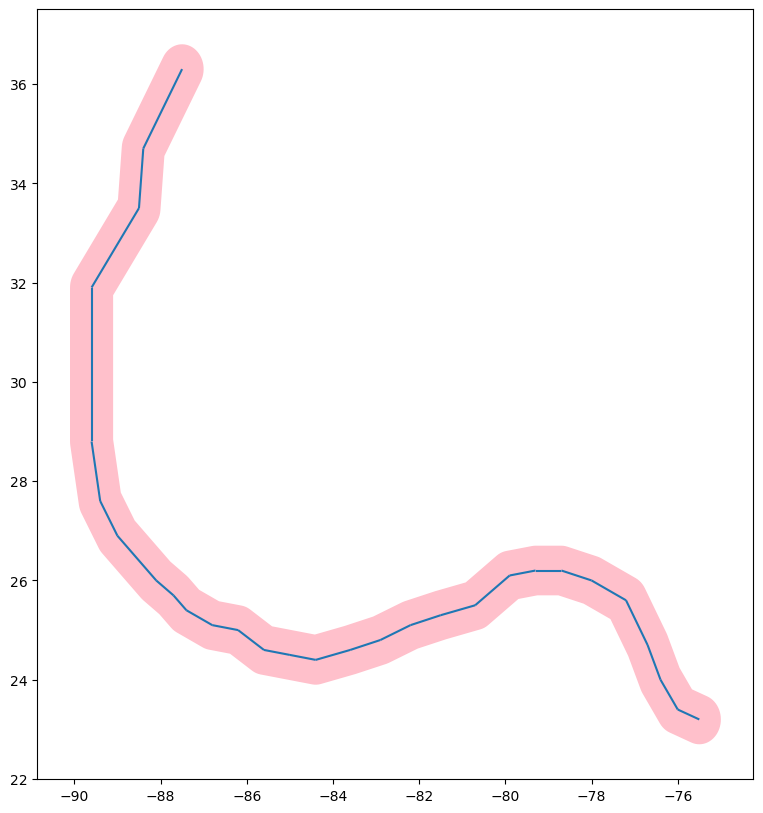

In [45]:
fig, ax = plt.subplots(1, figsize=(20,10))
gdf_track_buffer.plot(ax=ax, color="pink", )
mdf_traj.plot(ax=ax);

<Axes: >

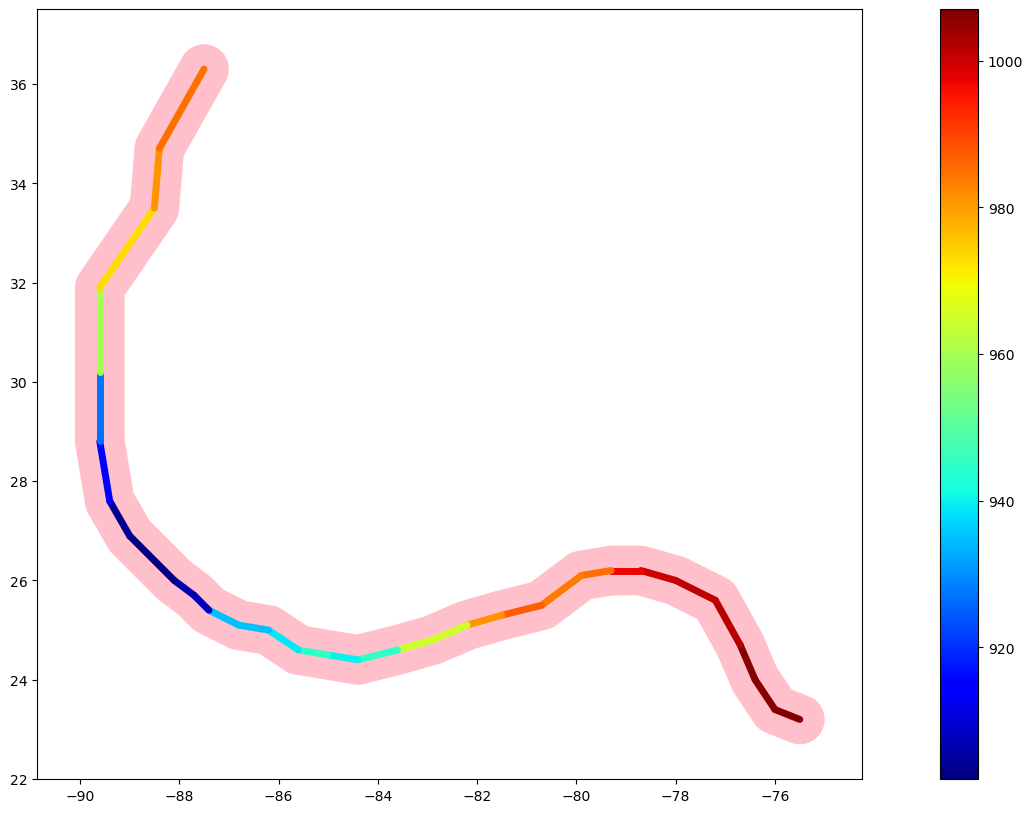

In [46]:
fig, ax = plt.subplots(1, figsize=(20,10))
mdf_traj.plot(ax=ax, legend="true", 
              capstyle='round',
              column="pressure", 
              linewidth=5,
              cmap='jet');
gdf_track_buffer.plot(ax=ax, color="pink", )

In [47]:
pres_plot = mdf_traj.hvplot(c="pressure", 
                hover_cols=["max_winds", "max_gust"],
                cmap="jet")
path_plot = gdf_track_buffer.hvplot(color="pink")

pres_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (pressure,max_winds,max_gust)
   .Points.I :Points   [Longitude,Latitude]   (pressure,triangle_angle,max_winds,max_gust)

We can select the background image with the by setting the `tiles` parameter with one of the options:

   ‘CartoDark’, ‘CartoEco’, ‘CartoLight’, ‘CartoMidnight’, 
   ‘EsriImagery’, ‘EsriNatGeo’, ‘EsriReference’, ’EsriTerrain’,
   ‘EsriUSATopo’, ‘OSM’, ‘StamenLabels’, ‘StamenTerrain’,
   ‘StamenTerrainRetina’, ‘StamenToner’, ‘StamenTonerBackground’,
   ‘StamenWatercolor’, ‘Wikipedia’ (default)


In [48]:
mdf_traj.hvplot(c="pressure", 
           tiles="EsriImagery",
                hover_cols=["max_winds", "max_gust"],
                width=900,
                height=600,
            xlim=(-100, -60), 
            ylim=(22, 43.5),
           cmap="jet")

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (pressure,max_winds,max_gust)
   .Points.I :Points   [Longitude,Latitude]   (pressure,triangle_angle,max_winds,max_gust)

## <font color="red"> Data Collection and Analyses</font>

To track the movement of an object, we need to collect timeseries data:

- The date/time
- The location (latitude/longitude)
- Fields at each location.

From there, we need to:

- Use `Pandas` to create a DataFrame with "date/time", "latitude", "longitude", "field_name1", "field_name2", etc. as columns.
- Use `GeoPandas` to create a GeoDataFrame based on the `Pandas` DataFrame.
- Use `MovingPandas` to create a trajectory object.
- Perform analyses and visualization.